In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install YOLOv8 and OpenCV
!pip install -q ultralytics opencv-python

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.0 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import csv
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

# Load models
yolo_model = YOLO('yolov8n.pt')  # Object detection model
sign_model = load_model('/content/drive/MyDrive/traffic_sign_classifier_final.h5')  # Traffic sign classifier

train_dir = '/content/drive/MyDrive/Dataset/traffic_sign_classification_dataset/train'  # update if different

# Get class names from folder names
class_names = sorted(os.listdir(train_dir))
print("Detected class names:")
print(class_names)


# Parameters
focal_length = 800
object_real_heights = {
    "person": 1.7,
    "car": 1.5,
    "bus": 3.0,
    "truck": 3.2,
    "motorcycle": 1.4,
    "bicycle": 1.2,
    "traffic light": 2.0,
    "stop sign": 0.75,
}

# I/O Paths
input_image_path = '/content/drive/MyDrive/Dataset/Dataset/images/IMG_5266.JPG'
output_image_path = '/content/drive/MyDrive/Dataset/Final_Output/combined_output.jpg'
csv_output_path = '/content/drive/MyDrive/Dataset/Final_Output/combined_output.csv'

# Load input image
image = cv2.imread(input_image_path)
original_image = image.copy()
csv_data = []
index = 1

# --- Run YOLOv8 Detection ---
results = yolo_model(image)

for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        cls_id = int(box.cls[0])
        label = yolo_model.names[cls_id]
        total_objects = len(boxes)

        # --- Estimate Distance ---
        object_height_pixels = abs(y2 - y1)
        if label in object_real_heights and object_height_pixels > 0:
            real_height = object_real_heights[label]
            distance = (real_height * focal_length) / object_height_pixels
            distance = round(distance, 2)
            distance_str = f"{distance} m"
        else:
            distance_str = "N/A"

        # --- Detect Traffic Sign if applicable ---
        sign_label = None
        if label in ['stop sign', 'traffic light', 'sign']:  # Extend this logic if needed
            crop = original_image[y1:y2, x1:x2]
            try:
                resized = cv2.resize(crop, (224, 224))
                preprocessed = preprocess_input(img_to_array(resized))
                preprocessed = np.expand_dims(preprocessed, axis=0)
                prediction = sign_model.predict(preprocessed)[0]
                sign_class = np.argmax(prediction)
                sign_label = class_names[sign_class]
            except Exception as e:
                sign_label = "Unknown"

        # --- Annotate Image ---
        label_text = f'{label} {conf:.2f} | {distance_str}'
        if sign_label:
            label_text += f' | Sign: {sign_label}'

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # --- Save CSV Row ---
        csv_data.append([
            index,
            input_image_path,
            label,
            round(conf, 2),
            distance_str,
            total_objects,
            sign_label if sign_label else "N/A"
        ])
        index += 1

# Ensure the directory exists before saving CSV
os.makedirs(os.path.dirname(csv_output_path), exist_ok=True)

# Save CSV
with open(csv_output_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Index", "Image Path", "Detected Object", "Confidence Score",
                     "Estimated Distance", "Total Objects", "Traffic Sign Label"])
    writer.writerows(csv_data)

print(f"📁 CSV file saved at: {csv_output_path}")



Detected class names:
['ALL_MOTOR_VEHICLE_PROHIBITED', 'AXLE_LOAD_LIMIT', 'BARRIER_AHEAD', 'BULLOCK_AND_HANDCART_PROHIBITED', 'BULLOCK_PROHIBITED', 'CATTLE', 'COMPULSARY_AHEAD', 'COMPULSARY_AHEAD_OR_TURN_LEFT', 'COMPULSARY_AHEAD_OR_TURN_RIGHT', 'COMPULSARY_CYCLE_TRACK', 'COMPULSARY_KEEP_LEFT', 'COMPULSARY_KEEP_RIGHT', 'COMPULSARY_MINIMUM_SPEED', 'COMPULSARY_SOUND_HORN', 'COMPULSARY_TURN_LEFT', 'COMPULSARY_TURN_LEFT_AHEAD', 'COMPULSARY_TURN_RIGHT', 'COMPULSARY_TURN_RIGHT_AHEAD', 'CROSS_ROAD', 'CYCLE_CROSSING', 'CYCLE_PROHIBITED', 'DANGEROUS_DIP', 'DIRECTION', 'FALLING_ROCKS', 'FERRY', 'GAP_IN_MEDIAN', 'GIVE_WAY', 'GUARDED_LEVEL_CROSSING', 'HANDCART_PROHIBITED', 'HEIGHT_LIMIT', 'HORN_PROHIBITED', 'HUMP_OR_ROUGH_ROAD', 'LEFT_HAIR_PIN_BEND', 'LEFT_HAND_CURVE', 'LEFT_REVERSE_BEND', 'LEFT_TURN_PROHIBITED', 'LENGTH_LIMIT', 'LOAD_LIMIT', 'LOOSE_GRAVEL', 'MEN_AT_WORK', 'NARROW_BRIDGE', 'NARROW_ROAD_AHEAD', 'NO_ENTRY', 'NO_PARKING', 'NO_STOPPING_OR_STANDING', 'OVERTAKING_PROHIBITED', 'PASS_EITHE

✅ Annotated image saved at: /content/drive/MyDrive/Dataset/Final_Output/combined_output.jpg


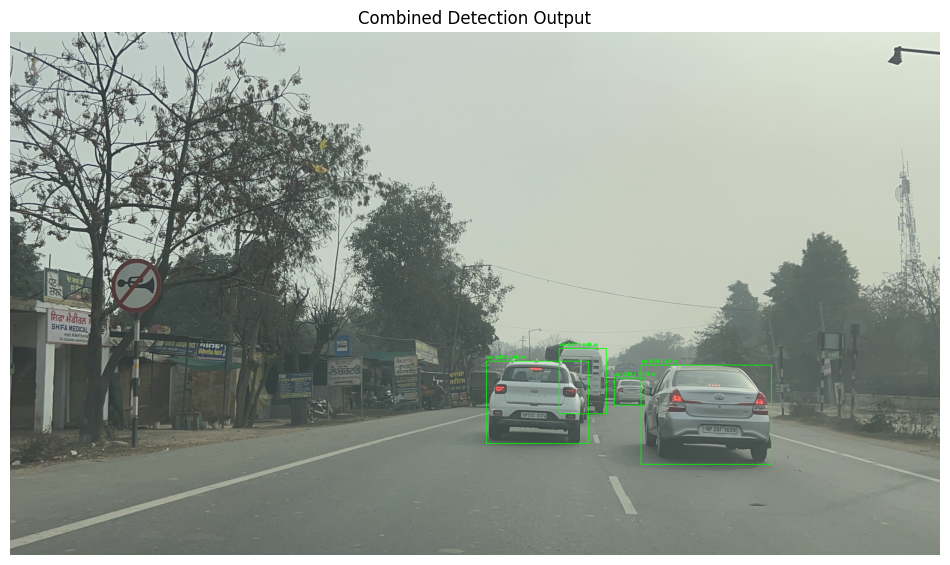

In [ ]:
# Save annotated image
cv2.imwrite(output_image_path, image)
print(f"✅ Annotated image saved at: {output_image_path}")

# Display in notebook
from IPython.display import Image, display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title('Combined Detection Output')
plt.show()



0: 384x640 2 cars, 184.9ms
Speed: 6.8ms preprocess, 184.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
✅ Saved annotated image: /content/drive/MyDrive/Dataset/Final_Output/combined_output.jpg


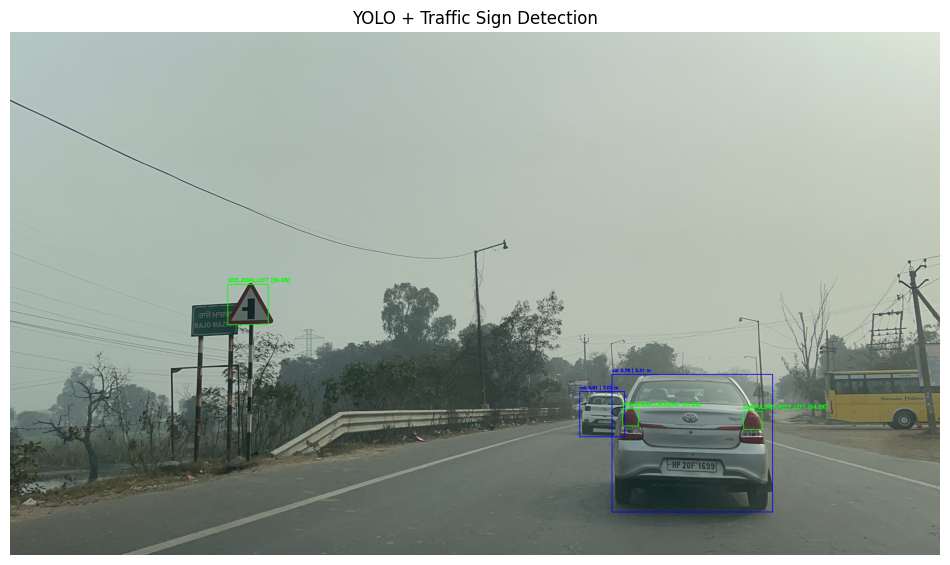

📁 CSV saved to: /content/drive/MyDrive/Dataset/Final_Output/combined_output.csv


In [ ]:
import os
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# === Paths ===
input_image_path = '/content/drive/MyDrive/Dataset/Dataset/images/IMG_5262.JPG'
#input_image_path = '/content/drive/MyDrive/Dataset/traffic_sign_classification_dataset/train/ALL_MOTOR_VEHICLE_PROHIBITED/00001.jpg'
output_image_path = '/content/drive/MyDrive/Dataset/Final_Output/combined_output.jpg'
csv_output_path = '/content/drive/MyDrive/Dataset/Final_Output/combined_output.csv'
model_path = "/content/drive/MyDrive/traffic_sign_classifier_final.h5"
class_dir = '/content/drive/MyDrive/Dataset/traffic_sign_classification_dataset/train'  # Folder with traffic sign subfolders

# === Ensure output directory exists ===
os.makedirs(os.path.dirname(csv_output_path), exist_ok=True)

# === Load models ===
yolo_model = YOLO('yolov8n.pt')  # Pretrained YOLO
sign_model = load_model(model_path)

# === Load class names from folder structure ===
class_names = sorted(os.listdir(class_dir))

# === Traffic object real-world heights for distance estimation ===
focal_length = 800
object_real_heights = {
    "person": 1.7,
    "car": 1.5,
    "bus": 3.0,
    "truck": 3.2,
    "motorcycle": 1.4,
    "bicycle": 1.2,
    "traffic light": 2.0,
    "stop sign": 0.75,
}

# === Preprocess for traffic sign classifier ===
def preprocess_roi(roi):
    roi = cv2.resize(roi, (224, 224))
    roi = roi.astype("float32") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    return roi

# === Load image ===
original_img = cv2.imread(input_image_path)
image = original_img.copy()

# === YOLO Object Detection + Distance Estimation ===
results = yolo_model(image)
csv_data = []
index = 1

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        cls_id = int(box.cls[0])
        label = yolo_model.names[cls_id]
        total_objects = len(result.boxes)

        object_height_pixels = abs(y2 - y1)
        if label in object_real_heights and object_height_pixels > 0:
            real_height = object_real_heights[label]
            distance = (real_height * focal_length) / object_height_pixels
            distance = round(distance, 2)
            distance_str = f"{distance} m"
        else:
            distance_str = "N/A"

        # Draw YOLO bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, f'{label} {conf:.2f} | {distance_str}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        csv_data.append([
            index,
            input_image_path,
            label,
            round(conf, 2),
            distance_str,
            total_objects,
            "N/A"
        ])
        index += 1

# === Traffic Sign Detection using HSV Red Masking ===
hsv = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)

lower_red1 = np.array([0, 70, 50])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 70, 50])
upper_red2 = np.array([180, 255, 255])

mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
mask = mask1 | mask2

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 30 and h > 30:
        roi = original_img[y:y+h, x:x+w]
        processed = preprocess_roi(roi)
        preds = sign_model.predict(processed)
        label = class_names[np.argmax(preds)]
        confidence = np.max(preds)

        # Annotate traffic sign
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, f"{label} ({confidence*100:.1f}%)", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        csv_data.append([
            index,
            input_image_path,
            "Traffic Sign",
            round(confidence, 2),
            "N/A",
            len(contours),
            label
        ])
        index += 1

# === Save Image ===
cv2.imwrite(output_image_path, image)
print(f"✅ Saved annotated image: {output_image_path}")

# === Show Image ===
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("YOLO + Traffic Sign Detection")
plt.show()

# === Save CSV ===
with open(csv_output_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Index", "Image Path", "Detected Object", "Confidence Score",
                     "Estimated Distance", "Total Objects", "Traffic Sign Label"])
    writer.writerows(csv_data)

print(f"📁 CSV saved to: {csv_output_path}")
